Might do this concurrently in PyTorch and Keras

In [1]:
%load_ext autoreload
%autoreload 2

import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import fmin_l_bfgs_b
import scipy

from keras.models import Model
from keras import metrics
from keras import backend as K

from vgg16_avg import VGG16_Avg as vgg

%matplotlib inline

Using TensorFlow backend.


In [2]:
path = '../data/train/'

In [3]:
fnames = glob.glob(path+'**/*.JPEG', recursive=True)
n = len(fnames); n

19439

In [4]:
fn = fnames[2090]; fn

'../data/train/n02102318/n02102318_10231.JPEG'

In [5]:
fn = '../data/train/n01558993/n01558993_9684.JPEG'

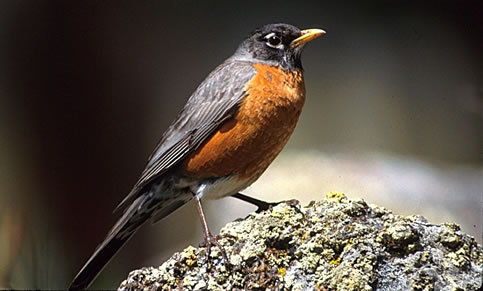

In [6]:
img=Image.open(fn); img

Need to subtract the VGG mean to make it work w/ VGG

In [7]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255).astype(np.uint8)

Also reshape to add the "batch_size"

In [8]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

Here we get a pretrained net (VGG but with max pooling replaced with avg pooling to retain information)

In [9]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)

In [10]:
class Evaluator(object):
    def __init__(self, f, shape): self.f, self.shp = f, shape
        
    def loss(self, x):
        loss_, self.grads_ = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)
    
    def grads(self, x):
        return self.grads_.flatten().astype(np.float64)

In [11]:
def solve_image(eval_obj, img, niter):
    for _ in range(niter):
        img, min_val, info = fmin_l_bfgs_b(eval_obj.loss, img.flatten(),
                                        fprime=eval_obj.grads, maxfun=40)
        img = np.clip(img, -127, 127)
        print('Current loss value:', min_val)
    return img

First need to set up the image part - aka, put it through ~5 layers of VGG

In [12]:
model = vgg(include_top=False)

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

Choose the first conv on the fifth layer (can check out different ones, but this is the one they use)

In [14]:
layer = model.get_layer('block5_conv1').output

In [15]:
partial_model = Model(model.input, layer)

In [16]:
targ = partial_model.predict(img_arr)

In [17]:
targ.shape

(1, 18, 30, 512)

In [18]:
metrics.mse(layer, targ)

<tf.Tensor 'Mean:0' shape=(?, 18, 30) dtype=float32>

In [19]:
img_arr.shape

(1, 291, 483, 3)

In the most recent Keras, the MSE only takes the mean along the last axis (I guess because it's thinking about batches, or something). Here we want it over all the input pixels so I'm just writing it here

In [20]:
def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

In [21]:
loss = mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

In [22]:
y = solve_image(evaluator, x, 10)

Current loss value: 20.0992927551
Current loss value: 8.4069890976
Current loss value: 5.6353058815
Current loss value: 4.36779022217
Current loss value: 3.56576895714
Current loss value: 3.04804205894
Current loss value: 2.67997908592
Current loss value: 2.62110304832
Current loss value: 2.61661219597
Current loss value: 2.24612045288


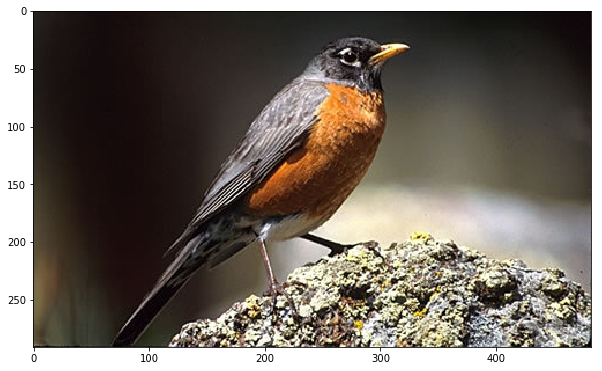

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(deproc(img_arr.copy(), shp)[0])

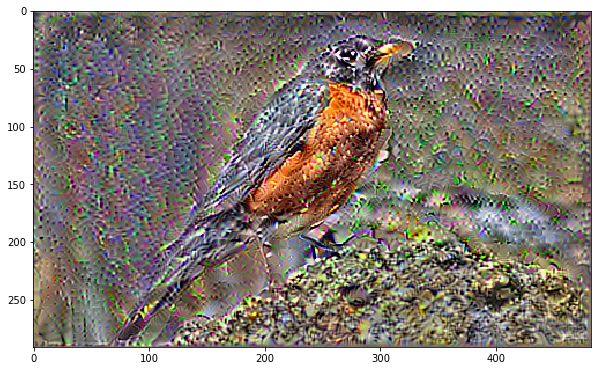

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(deproc(y.copy(), shp)[0])

OK! Now for the style part. Same thing, but with a given style. Gonna use this picasso image that I got off Google

In [25]:
picasso_fp = '../data/picasso.jpg'

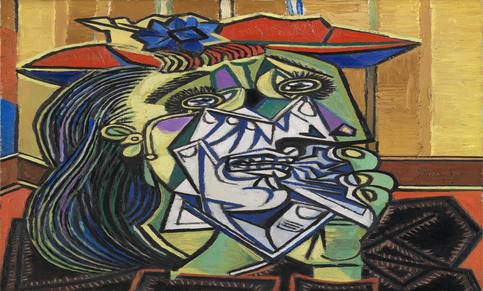

In [26]:
style_img = Image.open(picasso_fp) ; style_img

In [27]:
style_arr = preproc(np.expand_dims(style_img,0)[:,:,:,:3])
style_shp = style_arr.shape

In [29]:
model = vgg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

We're gonna use several layers here. We could have also done this for the style bits too.

In [30]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]

In [31]:
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

We use the gramian matrix. No one really knows why it works, other than because it works out how much the features correlate and therefore throws away all location data whilst keeping 'texture' data

In [32]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [33]:
def style_loss(x, targ): return mse(gram_matrix(x), gram_matrix(targ))

In [34]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

In [35]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)

In [36]:
y = solve_image(evaluator, x, 10)

Current loss value: 254.406066895
Current loss value: 32.4013175964
Current loss value: 9.18036746979
Current loss value: 4.22024774551
Current loss value: 2.60315871239
Current loss value: 1.64461219311
Current loss value: 1.1929371357
Current loss value: 1.07414102554
Current loss value: 1.09205508232
Current loss value: 1.06953167915


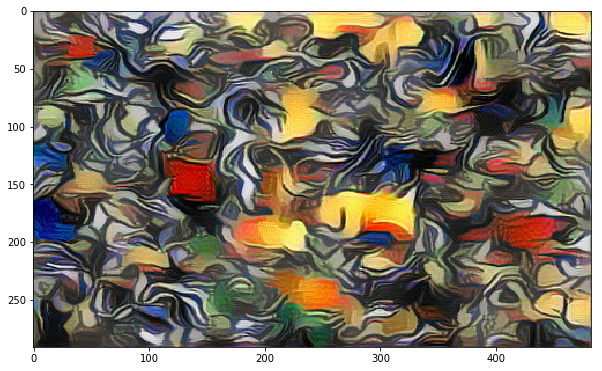

In [37]:
plt.figure(figsize=(10,10))
plt.imshow(deproc(y.copy(), shp)[0])

Putting it together!

In [38]:
model = vgg(include_top=False, input_shape=shp[1:])
outputs = {l.name:l.output for l in model.layers}

In [39]:
content_layer = model.get_layer('block4_conv2').output
style_layers = [outputs['block{}_conv1'.format(o)] for o in range(1,6)]
content_model = Model(model.input, content_layer)
style_model = Model(model.input, style_layers)

In [40]:
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]
content_targ = K.variable(content_model.predict(img_arr))

Content loss we're dividing by 10 to let the style have more of a look in.

TO WRITE: the weights, number of style layers, content loss weighting are important. Figure out how important!

In [41]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [42]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2, w in zip(style_layers, style_targs, style_wgts))
loss += mse(content_layer, content_targ)/15
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [43]:
evaluator = Evaluator(transfer_fn, shp)

In [44]:
x = rand_img(shp)

In [45]:
y = solve_image(evaluator, x, 10)

Current loss value: 508.265228271
Current loss value: 260.914428711
Current loss value: 202.641433716
Current loss value: 174.411468506
Current loss value: 157.380493164
Current loss value: 146.975982666
Current loss value: 140.268569946
Current loss value: 135.81362915
Current loss value: 132.105270386
Current loss value: 129.489730835


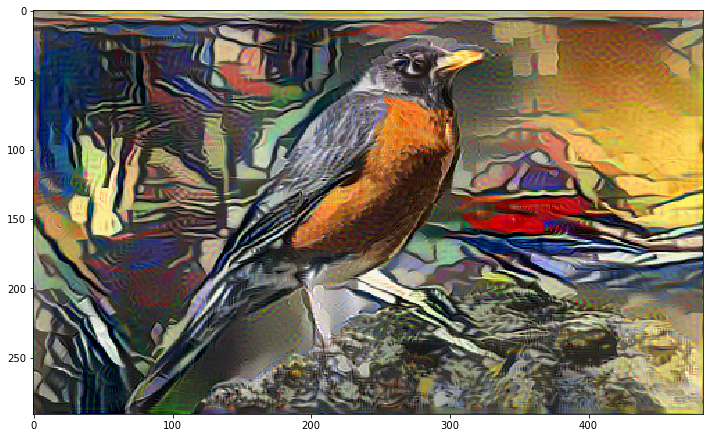

In [46]:
plt.figure(figsize=(12,12))
plt.imshow(deproc(y.copy(), shp)[0])